In [1]:
#Dated 2nd August, 2022

import numpy as np # For array operations
import matplotlib.pyplot as plt
import cv2 as cv # Mostly for showing and normalization
import os #To iterate through directories and join paths
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle

In [2]:
# Just some helper methods, that we will use later down the road

def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

In [4]:
data_dir = r'F:\FYP DATA\Dataset\Splitted Dataset Without Augementation\train'
classes = ['No-Pathologies', 'Pathological']
img_height = 120
img_width = 50

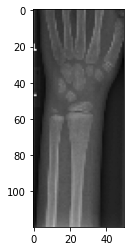

In [5]:
img_index = randint(0, 3000)
class_index = randint(0, 1)

img = cv.imread(os.path.join(os.path.join(data_dir, classes[class_index]), 
                             os.listdir(os.path.join(data_dir, classes[class_index]))[img_index]), cv.IMREAD_GRAYSCALE)
r_img = resize_image(img, img_width, img_height)

plt.imshow(r_img, cmap='gray')
plt.show()

In [6]:
# Creating training data
def get_data(data_dir, classes, img_width, img_height):
    data = []
    for a_class in classes:
        path = os.path.join(data_dir, a_class)
        class_num = classes.index(a_class)

        for image in os.listdir(path):
            img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
            resized_img_array = resize_image(img_array, img_width, img_height)
            data.append([resized_img_array, class_num])
            
    return data

In [ ]:
training_data = get_data(data_dir, classes, img_width, img_height)

In [5]:
training_data[0]

[array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [ 90,  54,  40, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  66, 111, 169],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 0]

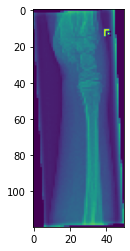

In [8]:
plt.imshow(training_data[0][0])
plt.show()

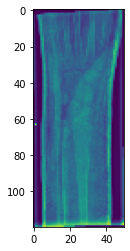

In [9]:
# Shuffling the training data (IMPORTANT)
shuffle(training_data)
plt.imshow(training_data[0][0])
plt.show()

In [7]:
# Seperating features from the labels
def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

In [11]:
X_train, y_train = sep_features_labels(training_data)

In [8]:
#Reshaping the features 
def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float')/255.0
    # y_train = preprocessing.LabelEncoder().fit_transform(y_train)
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

In [14]:
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

In [12]:
def pickle_save(x_name, y_name, X, y):
    pickle_out = open(f'{x_name}.pickle', "wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open(f'{y_name}.pickle', 'wb')
    pickle.dump(y, pickle_out)
    pickle_out.close()

In [13]:
def pickle_load(x_name, y_name):    
    pickle_in = open(x_name, 'rb')
    X = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open(y_name, 'rb')
    y = pickle.load(pickle_in)
    pickle_in.close()
    return X, y

In [21]:
pickle_save('X_train', 'y_train', X_train, y_train)

In [15]:
X_train, y_train = pickle_load(r'D:\FYP\Loaded Pickle Data\X_train.pickle', r'D:\FYP\Loaded Pickle Data\y_train.pickle')

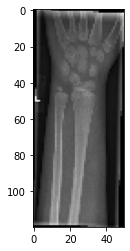

In [16]:
plot_image(X_train[5])

In [9]:
def getConvModel(input_shape, num_kernels, hidden_neurons, num_layers):
    model = Sequential()
    model.add(Conv2D(num_kernels, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(0, num_layers - 1):
        model.add(Conv2D(num_kernels, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
#     model.add(Dense(hidden_neurons, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(hidden_neurons, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [29]:
conv_model = getConvModel(X_train.shape[1:], 64, 128, 4)

In [55]:
val_data = get_data(r'D:\FYP\Dataset\Output Dataset\val', classes, img_width, img_height)
shuffle(val_data)
X_val, y_val = sep_features_labels(val_data)
X_val, y_val = reshape(X_val, y_val, img_width, img_height)

In [56]:
pickle_save('X_val', 'y_val', X_val, y_val)

In [10]:
X_val, y_val = pickle_load('X_val', 'y_val')

In [30]:
conv_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10, verbose=1)

Epoch 1/10
108/108 [==============================] - 5s 45ms/step - loss: 0.5381 - accuracy: 0.7206 - val_loss: 0.6493 - val_accuracy: 0.6679
Epoch 2/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4871 - accuracy: 0.7628 - val_loss: 0.6102 - val_accuracy: 0.6723
Epoch 3/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4649 - accuracy: 0.7738 - val_loss: 0.5936 - val_accuracy: 0.7316
Epoch 4/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4416 - accuracy: 0.7880 - val_loss: 0.5720 - val_accuracy: 0.7604
Epoch 5/10
108/108 [==============================] - 5s 43ms/step - loss: 0.4239 - accuracy: 0.7968 - val_loss: 0.4970 - val_accuracy: 0.7584
Epoch 6/10
108/108 [==============================] - 5s 43ms/step - loss: 0.3967 - accuracy: 0.8154 - val_loss: 0.4689 - val_accuracy: 0.7715
Epoch 7/10
108/108 [==============================] - 5s 43ms/step - loss: 0.3762 - accuracy: 0.8255 - val_loss: 0.4691 - val_accuracy: 0.7840

In [13]:
dense_layers = [0, 1]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3, 4]

models = []

for dense_layer in dense_layers:
	for layer_size in layer_sizes:
		for conv_layer in conv_layers:
			NAME = f'wri-{conv_layer}-conv-{layer_size}-layer-{dense_layer}-dense-{int(time.time())}'
			tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
            
			print(NAME)
			model = Sequential()
			model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
			model.add(BatchNormalization())
			model.add(MaxPooling2D(pool_size=(2, 2)))

			for i in range(conv_layer - 1):
				model.add(Conv2D(layer_size, (3, 3), activation='relu'))
				model.add(MaxPooling2D(pool_size=(2, 2)))

			model.add(Flatten())
			for l in range(dense_layer):
				model.add(Dense(512, activation='relu'))
				model.add(Dropout(0.5))

			model.add(Dense(1, activation='sigmoid'))
			model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
			model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10, callbacks=[tensorboard])
			val_loss, val_acc = model.evaluate(X_val, y_val)
			models.append([f'{NAME}, LOSS: {val_loss}, ACC: {val_acc}', model])

wri-1-conv-32-layer-0-dense-1659619999
Epoch 1/10
108/108 [==============================] - 4s 23ms/step - loss: 0.5929 - accuracy: 0.6952 - val_loss: 0.6387 - val_accuracy: 0.6667
Epoch 2/10
108/108 [==============================] - 2s 19ms/step - loss: 0.4805 - accuracy: 0.7612 - val_loss: 0.6240 - val_accuracy: 0.6962
Epoch 3/10
108/108 [==============================] - 2s 19ms/step - loss: 0.4317 - accuracy: 0.7932 - val_loss: 0.5895 - val_accuracy: 0.6954
Epoch 4/10
108/108 [==============================] - 2s 19ms/step - loss: 0.3906 - accuracy: 0.8215 - val_loss: 0.5805 - val_accuracy: 0.7316
Epoch 5/10
108/108 [==============================] - 2s 19ms/step - loss: 0.3590 - accuracy: 0.8384 - val_loss: 0.5290 - val_accuracy: 0.7365
Epoch 6/10
108/108 [==============================] - 2s 18ms/step - loss: 0.3275 - accuracy: 0.8562 - val_loss: 0.5332 - val_accuracy: 0.7353
Epoch 7/10
108/108 [==============================] - 2s 19ms/step - loss: 0.2918 - accuracy: 0.8753 - 

Epoch 6/10
108/108 [==============================] - 9s 85ms/step - loss: 0.4128 - accuracy: 0.8028 - val_loss: 0.4673 - val_accuracy: 0.7747
Epoch 7/10
108/108 [==============================] - 9s 84ms/step - loss: 0.3894 - accuracy: 0.8212 - val_loss: 0.4752 - val_accuracy: 0.7769
Epoch 8/10
108/108 [==============================] - 9s 84ms/step - loss: 0.3579 - accuracy: 0.8357 - val_loss: 0.6328 - val_accuracy: 0.7301
Epoch 9/10
108/108 [==============================] - 9s 84ms/step - loss: 0.3419 - accuracy: 0.8448 - val_loss: 0.5167 - val_accuracy: 0.7670
Epoch 10/10
128/128 [==============================] - 1s 8ms/step - loss: 0.7195 - accuracy: 0.7336
wri-4-conv-128-layer-0-dense-1659620534
Epoch 1/10
108/108 [==============================] - 11s 90ms/step - loss: 0.5566 - accuracy: 0.7137 - val_loss: 0.6681 - val_accuracy: 0.6748
Epoch 2/10
108/108 [==============================] - 9s 87ms/step - loss: 0.4854 - accuracy: 0.7614 - val_loss: 0.6560 - val_accuracy: 0.7272


Epoch 9/10
108/108 [==============================] - 3s 24ms/step - loss: 0.3747 - accuracy: 0.8294 - val_loss: 0.4753 - val_accuracy: 0.7808
Epoch 10/10
128/128 [==============================] - 0s 3ms/step - loss: 0.4894 - accuracy: 0.7737
wri-1-conv-64-layer-1-dense-1659620743
Epoch 1/10
108/108 [==============================] - 6s 49ms/step - loss: 1.5728 - accuracy: 0.6502 - val_loss: 0.6716 - val_accuracy: 0.6556
Epoch 2/10
108/108 [==============================] - 5s 47ms/step - loss: 0.5447 - accuracy: 0.6900 - val_loss: 0.6383 - val_accuracy: 0.6910
Epoch 3/10
108/108 [==============================] - 5s 47ms/step - loss: 0.5088 - accuracy: 0.7276 - val_loss: 0.5956 - val_accuracy: 0.7016
Epoch 4/10
108/108 [==============================] - 5s 47ms/step - loss: 0.4831 - accuracy: 0.7499 - val_loss: 0.5847 - val_accuracy: 0.7228
Epoch 5/10
108/108 [==============================] - 5s 47ms/step - loss: 0.4514 - accuracy: 0.7705 - val_loss: 0.6214 - val_accuracy: 0.6925
Ep

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_20/conv2d_50/Conv2D' defined at (most recent call last):
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ammar\AppData\Local\Temp\ipykernel_2272\3026519418.py", line 30, in <cell line: 7>
      model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10, callbacks=[tensorboard])
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\Ammar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_20/conv2d_50/Conv2D'
OOM when allocating tensor with shape[132,128,118,48] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_20/conv2d_50/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_163378]

In [15]:
for model_name, model in models:
    print(model_name)

wri-1-conv-32-layer-0-dense-1659619999, LOSS: 0.8248814344406128, ACC: 0.6735547184944153
wri-2-conv-32-layer-0-dense-1659620023, LOSS: 0.6774890422821045, ACC: 0.6787207722663879
wri-3-conv-32-layer-0-dense-1659620050, LOSS: 0.5798473954200745, ACC: 0.7444034218788147
wri-4-conv-32-layer-0-dense-1659620078, LOSS: 0.5151875615119934, ACC: 0.7729397416114807
wri-1-conv-64-layer-0-dense-1659620106, LOSS: 0.8373152613639832, ACC: 0.7052890658378601
wri-2-conv-64-layer-0-dense-1659620142, LOSS: 0.5737637281417847, ACC: 0.7542435526847839
wri-3-conv-64-layer-0-dense-1659620188, LOSS: 0.5170226693153381, ACC: 0.7712177038192749
wri-4-conv-64-layer-0-dense-1659620236, LOSS: 0.5026945471763611, ACC: 0.7813038229942322
wri-1-conv-128-layer-0-dense-1659620285, LOSS: 0.7631211876869202, ACC: 0.7102091312408447
wri-2-conv-128-layer-0-dense-1659620350, LOSS: 0.6071333289146423, ACC: 0.7461254596710205
wri-3-conv-128-layer-0-dense-1659620440, LOSS: 0.7194558382034302, ACC: 0.7335793375968933
wri-4-c

In [35]:
for model_name, model in models:
    print(model_name)

wri-1-conv-128-layer-1-dense-1659622051, LOSS: 1.2844340801239014, ACC: 0.6947109699249268
wri-2-conv-128-layer-1-dense-1659622171, LOSS: 0.6976880431175232, ACC: 0.7345633506774902
wri-3-conv-128-layer-1-dense-1659622274, LOSS: 0.5551664233207703, ACC: 0.7141451239585876
wri-4-conv-128-layer-1-dense-1659622376, LOSS: 0.4715929329395294, ACC: 0.8034440279006958


In [37]:
# curr_model = models[len(models) - 1][1]
# model_name = (models[-1][0]).split(', ')[0]

In [17]:
# serialize model to JSON
def save_model(model_name, model):
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{model_name}.h5")
    print("Saved model to disk")

In [18]:
# load json and create model\
def load_model(model_name):
    json_file = open(f'{model_name}.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    conv_model = model_from_json(loaded_model_json)
    # load weights into new model
    conv_model.load_weights(f"{model_name}.h5")
    print("Loaded model from disk")
    return conv_model

In [38]:
# save_model(model_name, curr_model)

Saved model to disk


In [6]:
conv_model = load_model('wri-4-conv-128-layer-1-dense-1659622376')

Loaded model from disk


In [7]:
conv_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [24]:
# Load testing data
testing_data = get_data(r'D:\FYP\Dataset\Output Dataset\test', classes, img_width, img_height)
X_test, y_test = sep_features_labels(testing_data)
X_test, y_test = reshape(X_test, y_test, img_width, img_height)

In [25]:
pickle_save('X_test', 'y_test', X_test, y_test)

In [8]:
X_test, y_test = pickle_load('X_test', 'y_test')

In [9]:
val_loss, val_acc = conv_model.evaluate(X_test, y_test)

64/64 [==============================] - 13s 201ms/step - loss: 0.4614 - accuracy: 0.8142


In [10]:
print(f'Loss = {val_loss}, Accuracy: {val_acc}')

Loss = 0.4614410698413849, Accuracy: 0.8141592741012573


In [11]:
def normalize_img(img):
    r_img = resize_image(img, img_width, img_height)
    r_img = img_to_array(r_img, data_format='channels_last')
    r_img = np.array(r_img).reshape(-1, img_height, img_width, 1)
    r_img = (np.array(r_img)).astype('float')/255.0
    return r_img

In [12]:
def get_img(img_path):
     img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
     r_img = resize_image(img, img_width, img_height)
     return r_img

In [13]:
def get_predicted_class(pred_prob):
    if pred_prob > .5:
        return classes[1]
    return classes[0]

In [14]:
def predict_class(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    r_img = normalize_img(img)
    predict = conv_model.predict(r_img)
    pred_prob = predict[0][0]
    return pred_prob, get_predicted_class(pred_prob)

In [18]:
test_data = []
for a_class in classes:
    path = os.path.join(r'D:\FYP\Dataset\Output Dataset\test', a_class)
    for img in os.listdir(path):
        test_data.append([os.path.join(path, img), a_class])
shuffle(test_data)

In [19]:
def get_random_img(data):
    i = randint(0, len(data) - 1)
    return data[i][0], data[i][1]

In [21]:
rand_img, actual_lbl = get_random_img(test_data)
print(f'Path: {rand_img}, Label: {actual_lbl}')

Path: D:\FYP\Dataset\Output Dataset\test\Pathological\1440_0853819663_01_WRI-R2_M013.png, Label: Pathological


In [25]:
# set manual image path
# img_path = r'D:\FYP\Dataset\Output Dataset\test\No-Pathologies\1003_0408953722_01_WRI-R1_M011_0.png'
actual_lbl=''
rand_img, actual_lbl = get_random_img(test_data)
prob, class_label = predict_class(rand_img)
print(f'\nPredicted Label: {class_label}\nProbability of Pathology: {prob}\nActual Label: {actual_lbl}')

1/1 [==============================] - 0s 29ms/step

Predicted Label: Pathological
Probability of Pathology: 0.9763190150260925
Actual Label: Pathological


In [61]:
wrong =0
for i in range(10000):
    rand_img, actual_lbl = get_random_img(test_data)
    prob, class_label = predict_class(rand_img)
    
    if class_label != actual_lbl: 
        print(False)
        wrong += 1
    i+=1
    
print(wrong)    


1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 13ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 5ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [============

1/1 [==============================] - 0s 6ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 4ms/step
False
1/1 [==============================] - 0s 15ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 1ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 3ms/step
False
1/1 [==============================] - 0s 6ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 3ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 7ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=============

1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [===========

False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 6ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=======

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 5ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 5ms/step
False
1/1 [==============================] - 0s 7ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 3ms/step
False
1/1 [=============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 4ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 4ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==========

False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 6ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [====

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 6ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 8ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [===========

1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 3ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [===========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 7ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 7ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 1ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 5ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [===========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 3ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 4ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [=============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 5ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [===========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [===========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 4ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 0s/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [============

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 14ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 12ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [=========

In [62]:
print(wrong/10000)

0.192


<function matplotlib.pyplot.show(close=None, block=None)>

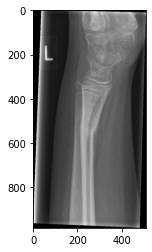

In [26]:
plt.imshow(cv.imread(rand_img, cv.IMREAD_GRAYSCALE), cmap='gray')
plt.show